# GNN Code, mostly taken from Luke van Poppering

### Latex Macros
$\newcommand{\Re}[1]{{\mathbb{R}^{{#1}}}}
\newcommand{\Rez}{{\mathbb{R}}}$

# Notes
* Node2vec, struct2vect, etc. construct embeddings without a particular task. So node classification is not necessary in order to obtain embeddings. 
* The `ge` library has default embeddings of size 128, which is obviously overkill for the Karate Club Dataset. 

In [2]:
%load_ext autoreload
%autoreload 2
#%tableofcontents

In [3]:
import torch
import torch_scatter
import torch_sparse
import torch_geometric
import tqdm.auto
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import GNN_Tools as GNNT

In [4]:
### We use the famous 'Karate Club' network as a test case. Our task is to
### predict the community to which each node belongs; formally, this would be
### called transductive binary node classification.

import networkx as nx
G = nx.karate_club_graph()

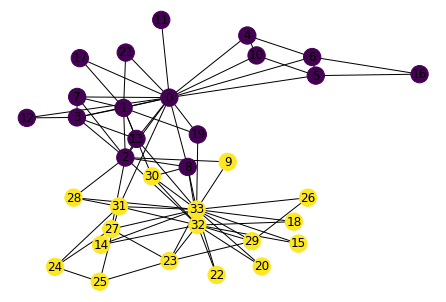

In [5]:
### Plot the network. We see it consists of a total of 34 nodes (numbered below 
### 0-33). Colors indicate class membership.
labels = [0 if G.nodes[idx]['club'] == 'Mr. Hi' else 1 for idx in range(len(G.nodes))]
pos = nx.drawing.layout.spring_layout(G)
nx.drawing.draw(G,pos=pos,with_labels=True,node_color=labels) 

In [9]:
### Write edge list to file.
### The attributes are synthetic
torch.manual_seed(0)
# All edges. Undirected edges appear twice: i->j and j->i
with open('edges.txt','w') as f:
  for edge in list(G.edges):
    f.write(f'{edge[0]} {edge[1]} {1.0}\n')
    # Karate Club file contains undirected edges
    f.write(f'{edge[1]} {edge[0]} {1.0}\n')

### Write node metadata to file. Nodes belonging to class '0' have features
### drawn from N(1,1). Nodes belonging to class '1' have features drawn from 
### the standard normal. So the features are the class label + 16 random numbers, 
### where the mean depends on the class. 
nb_Gnodes = len(list(G.nodes))
nb_rand_features = 10   # change value for experimentation
rands = np.random.randn(nb_Gnodes, 16)
with open('nodes.txt','w') as f:
  for node in list(G.nodes):
      if G.nodes[node]['club'] == 'Mr. Hi':
          X_str = " ".join([str(.5 + rand) for rand in np.random.randn(nb_rand_features)])
          f.write(f'{node} 0 ' + X_str + ' \n')
      elif G.nodes[node]['club'] == 'Officer':
          X_str = " ".join([str(rand) for rand in np.random.randn(nb_rand_features)])
          f.write(f'{node} 1 ' + X_str + ' \n')

### Read files into _Graph_ object.
karate_club_graph = GNNT.Graph()
karate_club_graph.read_edges('edges.txt')
karate_club_graph.read_node_metadata('nodes.txt')

In [12]:
### Write edge list to file.
### The attributes are synthetic
torch.manual_seed(0)
with open('edges.txt','w') as f:
  for edge in list(G.edges):
    f.write(f'{edge[0]} {edge[1]} {1.0}\n')

### Write node metadata to file. Nodes belonging to class '0' have features
### drawn from N(1,1). Nodes belonging to class '1' have features drawn from 
### the standard normal. So the features are the class label + 16 random numbers, 
### where the mean depends on the class. 
nb_Gnodes = len(list(G.nodes))
nb_rand_features = 16   # change value for experimentation
rands = np.random.randn(nb_Gnodes, 16)
with open('nodes.txt','w') as f:
  for node in list(G.nodes):
      if G.nodes[node]['club'] == 'Mr. Hi':
          X_str = " ".join([str(.5 + rand) for rand in np.random.randn(nb_rand_features)])
          f.write(f'{node} 0 ' + X_str + ' \n')
      elif G.nodes[node]['club'] == 'Officer':
          X_str = " ".join([str(rand) for rand in np.random.randn(nb_rand_features)])
          f.write(f'{node} 1 ' + X_str + ' \n')

### Read files into _Graph_ object.
karate_club_graph = GNNT.Graph()
karate_club_graph.read_edges('edges.txt')
karate_club_graph.read_node_metadata('nodes.txt')

In [13]:
len(G.nodes)
import numpy.linalg as alg
karate_club_graph.node_metadata;

In [14]:
graph = karate_club_graph

Linear model is 
$$ H^{n+1} = A H^n W $$
where $H\in \Re{N\times d}$, $A\in\Re{N\times N}$, and $W\in\Re{d\times d}$ and $d$ is the number of features. In our synthetic example, we have 16 features, one label. `

In [90]:
softmax = torch.nn.functional.softmax
relu = torch.nn.functional.relu
sigmoid = torch.nn.functional.sigmoid
tanh = torch.nn.functional.tanh
activation = sigmoid

def model(A, H0, W):
    """
    W : list of weights of different shapes
    """
    X = relu(A @ H0 @ W[0])
    #X = relu(A @ X @ W[0])
    X = sigmoid(A @ X @ W[1])
    # X = softmax(X, dim=1)   #  2 output dimensions
    #X = activation(X)   # 1 output dimension
    return X

In [130]:
### Create a hand-crafted GNN without using a formal model.

def model_setup(G, graph, frac_train=0.5):
    """
    G is a networkx graph
    graph is an instance of the Graph class (Luke VP)
    """
    # # Ensure result reproducibility
    # torch.manual_seed(100)
    nb_nodes = len(G.nodes)
    nb_edges = len(G.edges)
    A = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
    # Check that graph is undirected if ||A-A.T|| = 0
    
    # print("Model setup, check A")
    # for i in range(3):
    #   for j in range(34):
    #     if A[i,j]:
    #         print("edge: ", i, j)
    
    # ATTENTION: THE NODE INDICES ARE NOT PERMUTED. IMPORTANT or NOT? 

    # Kipf and Welling (2016)
    An = np.eye(nb_nodes) + A
    D = np.sum(An, axis=0)  # degree
    Dinvsq = np.diag(np.sqrt(1. / D))  # array
    An = Dinvsq @ An @ Dinvsq
    
    # max|eig[i]| = 1
    # eig = alg.eig(An)[0]
    # print("eig: ", np.sort(eig))
    
    H0 = graph.node_metadata
    H = H0[:,1:] # features
    Y = H0[:,0]  # labels
    
    # 0: training set (50%); 1: testing set (50%)
    # mask = torch.from_numpy(np.random.randint(0, 2, H0.shape[0]))
    mask = torch.from_numpy(np.random.choice(2, H0.shape[0], p=[frac_train, 1.-frac_train]))
 
    H0 = H  # features
    # Use -1 in case the matrix eventually changes number of dimensions
    nb_features = H0.shape[-1]  
    print("nb_features: ", nb_features)
    
    # Initialize W with random numbers and allow gradient 
    # computation of cost function with respect to (wrt) W

    W = []
    # I did initialize the weights, but only with non-scaled random numbers
    W.append( torch.rand(nb_features, nb_features, requires_grad=True) )
    # Binary classification (2 output features)
    #W1 = torch.rand(nb_features, 2, requires_grad=True)  # softmax output layer
    W.append( torch.rand(nb_features, 1, requires_grad=True) )  # sigmoid output layer
    
    # Glorot Initialization
    rmax = 1/nb_features**0.5
    for w in  W:
        torch.nn.init.uniform_(w, -rmax, rmax)
        
    An = torch.tensor(An, dtype=torch.float32)
    #A /= A.sum(dim=1)[:,None]  # Luke's suggestion, 2022-02-04. WHY this rescaling? 
    # A = torch.tensor(A, dtype=torch.float32)
    return An, H, H0, Y, W, mask

In [131]:
def cost(H, Y, mask, activation):
    """
    summation over all edges
    Training set: defined by mask[i] = 0
    H[i,0] is the probability of Y[i] == 1 (target probability)
    H[i,1] is the probability of Y[i] == 0 (target probability)
    """
    costf = 0
    
    if activation == "relu":
        for i in range(Y.shape[0]):
            if mask[i] == 0:  # training set
                costf -= (Y[i] * torch.log(H[i,0]) + (1-Y[i]) * torch.log(H[i,1]))
        
    elif activation == "sigmoid": 
        for i in range(Y.shape[0]):
            if mask[i] == 0:  # training set
                # costf -= torch.log(H[i,0])
                costf -= (Y[i] * torch.log(H[i,0]) + (1-Y[i]) * torch.log(1.-H[i,0]))


                
    else:
        print(f"activation {activation} is not supported.")
    
    return costf

In [132]:
def train(A, H, H0, Y, W, graph, mask, nb_epochs, activation):
    
    # Follow https://www.analyticsvidhya.com/blog/2021/08/linear-regression-and-gradient-descent-in-pytorch/

    print("cost(H0, Y, mask)")
    loss = [cost(H0, Y, mask, activation)]
    for epoch in range(nb_epochs):
        H = model(A, H0, W)
        costf = cost(H, Y, mask, activation)
        loss.append(costf)
        if np.isnan(costf.detach().item()):
            print("costf is NaN")
            break
        with torch.no_grad():
            # Why does it not work with the argument True?
            costf.backward(retain_graph=False)  # otherwise graph is discarded. How to regenerate it?
            lr= 1.e-2### # try with 1e-2, 1e-3,,1e-4
            for w in W:
                w -= lr * w.grad
                w.grad.zero_()
        if epoch % 100 == 0:
            print("============================")
            predict(A, H0, Y, W, mask, activation="sigmoid")
            pass
    return loss

In [133]:
def predict(A, H0, Y, W, mask, activation):
    
    # Follow https://www.analyticsvidhya.com/blog/2021/08/linear-regression-and-gradient-descent-in-pytorch/
    H = model(A, H0, W)
    
    if activation == "relu":
        count = [0,0]
        count_correct = [0,0]
        for i in range(H.shape[0]):
            if mask[i] == 1:
                count[0] += 1
                if H[i,0] > 0.5 and Y[i] > 0.9:
                    count_correct[0] += 1
                elif H[i,1] < 0.5 and Y[i] < 0.1:
                    count_correct[1] += 1
        perc0_corr = count_correct[0] / count[0]
        perc1_corr = count_correct[1] / count[0]
        print("sum(H): ", torch.sum(H, axis=0))
        print("Perc (%) class 0/1 correct: ", perc0_corr, perc1_corr)
    elif activation == "sigmoid":    # <<<< CASE BEING USED (2022-02-03)
        count_correct = [0,0]
        count = [0,0]
        for i in range(H.shape[0]):
            if mask[i] == 1: # test data
                count[1] += 1
                if H[i] > 0.5 and Y[i] > 0.9:
                    count_correct[1] += 1
                if H[i] < 0.5 and Y[i] < 0.1:
                    count_correct[1] += 1
            else:  # mask == 0, training data
                count[0] += 1
                if H[i] > 0.5 and Y[i] > 0.9:
                    count_correct[0] += 1
                if H[i] < 0.5 and Y[i] < 0.1:
                    count_correct[0] += 1
        perc0_corr = count_correct[0] / count[0]
        perc1_corr = count_correct[1] / count[1]
        print("Perc (%) class (training) correct: ", perc0_corr)
        print("Perc (%) class (testing) correct: ", perc1_corr)
    else:
        print("predict(): Incorrect activation function")
        return

In [149]:
A, H, H0, Y, W, mask = model_setup(G, graph, frac_train=0.1) 
print("H: ", H.shape)
# print("A: ", np.sort(alg.eig(A)[0]))
# print("sum(Y): ", torch.sum(Y).numpy())11111111111111111111
print(Y)  # half 0 and half 1 (correct labels)8888888
loss = train(A, H, H0, Y, W, graph, mask, nb_epochs=1501, activation="sigmoid")

nb_features:  16
H:  torch.Size([34, 16])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
        1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
cost(H0, Y, mask)
Perc (%) class (training) correct:  0.5
Perc (%) class (testing) correct:  0.5
Perc (%) class (training) correct:  0.5
Perc (%) class (testing) correct:  0.5
Perc (%) class (training) correct:  1.0
Perc (%) class (testing) correct:  0.71875
Perc (%) class (training) correct:  1.0
Perc (%) class (testing) correct:  0.78125
Perc (%) class (training) correct:  1.0
Perc (%) class (testing) correct:  0.8125
Perc (%) class (training) correct:  1.0
Perc (%) class (testing) correct:  0.8125
Perc (%) class (training) correct:  1.0
Perc (%) class (testing) correct:  0.78125
Perc (%) class (training) correct:  1.0
Perc (%) class (testing) correct:  0.78125
Perc (%) class (training) correct:  1.0
Perc (%) class (testing) correct:  0.8125
Perc (%) class (training) correct:  1.0
Perc (%) cl

In [128]:
loss[0:5]

[tensor(13.0068, grad_fn=<SubBackward0>),
 tensor(12.5939, grad_fn=<SubBackward0>),
 tensor(12.2144, grad_fn=<SubBackward0>),
 tensor(11.8349, grad_fn=<SubBackward0>),
 tensor(11.4537, grad_fn=<SubBackward0>)]

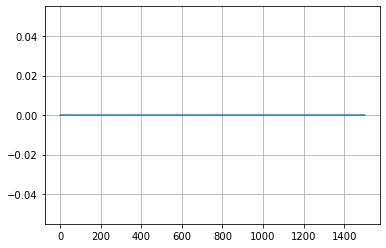

1501

In [15]:
plt.plot(loss) #[0:500])
plt.grid(True)
plt.show()
len(loss)

# I am not getting good accuracies for node classification. So I will do the following: 
* find a program on Github working with the Karate Club data
* Calculate accuracy with Luke's code, which uses sparse library
* Write my own code using Pytorch but without Sparse. 